# Core Imports

In [1]:
# Custom Imports
from polysaccharide import general
from polysaccharide.general import optional_in_place
from polysaccharide.extratypes import ResidueSmarts

from polysaccharide.molutils import reactions
from polysaccharide.molutils.rdmol.rdtypes import *
from polysaccharide.molutils.rdmol import rdcompare, rdconvert, rdkdraw, rdcompare, rdprops, rdbond, rdlabels

from polysaccharide.polymer import monomer as monoutils
from polysaccharide.polymer.monomer import MonomerInfo

from polysaccharide.polymer import building
import mbuild as mb

# Generic Imports
import re
from functools import partial, cached_property
from collections import defaultdict
from itertools import combinations, chain
from ast import literal_eval

# Numeric imports
import pandas as pd
import numpy as np

# File I/O
from pathlib import Path
import csv, json, openpyxl

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Generator, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty
from openmm.unit import Unit, Quantity

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdChemReactions

# Static Paths
RAW_DATA_PATH  = Path('raw_monomer_data')
PROC_DATA_PATH = Path('processed_monomer_data')
RXN_FILES_PATH = Path('rxn_smarts')
MONO_INFO_DIR  = Path('monomer_files')

/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Wa

# Building PDB files from monomer fragments

In [2]:
# defining reacting functional groups
reaction_pairs = {
    'NIPU' : ('cyclocarbonate', 'amine'),
    'urethane' : ('isocyanate', 'hydroxyl')
}

In [3]:
from polysaccharide.polymer.exceptions import SubstructMatchFailedError

pdb_path = Path('pdb_files')
pdb_path.mkdir(exist_ok=True)

DOP = 10
chemistries = ('urethane', 'NIPU')

failed = general.RecursiveDict()
for chemistry in chemistries:
    mono_src_dir = MONO_INFO_DIR / chemistry
    pdb_out_dir = pdb_path / chemistry
    pdb_out_dir.mkdir(exist_ok=True)

    for mono_path in mono_src_dir.iterdir():
        mono_info = MonomerInfo.from_file(mono_path)
        try:
            polymer = building.build_linear_polymer(mono_info.SMARTS, DOP=DOP, sequence='AB')  
            savepath = pdb_out_dir / f'{mono_path.stem}.pdb'
            polymer.save(general.asstrpath(savepath))
        except Exception as e:
            failed[chemistry][e.__class__.__name__][mono_path.stem] = mono_info

/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mbuild/conversion.py:1736: UserWarning: The bond orders will be guessed using pybelOBMol.PerceviedBondOrders()
  warn(


In [4]:
failed

defaultdict(<function polysaccharide.general.RecursiveDict.<locals>.<lambda>()>,
            {'urethane': defaultdict(<function polysaccharide.general.RecursiveDict.<locals>.<lambda>()>,
                         {'OSError': defaultdict(<function polysaccharide.general.RecursiveDict.<locals>.<lambda>()>,
                                      {'urethane_13': MonomerInfo(monomers={'isocyanate_TERM': '[*:1]-[#6:2](=[#8:3])-[#7:4](-[H:5])-[#6:6](-[H:7])(-[H:8])-[#6:9](-[H:10])(-[H:11])-[#6:12](-[H:13])(-[H:14])-[#6:15](-[H:16])(-[H:17])-[#6:18](-[H:19])(-[H:20])-[#6:21](-[H:22])(-[H:23])-[#7:24]=[#6:25]=[#8:26]', 'hydroxyl_TERM': '[*:1]-[#8:2]-[#6:3](-[H:4])(-[H:5])-[#6:6]1=[#7:7]-[#6:8](-[#6:9](-[H:10])(-[H:11])-[#8:12]-[H:13])=[#6:14](-[H:15])-[#6:16](-[H:17])=[#6:18]-1-[H:19]', 'isocyanate_MID': '[*:1]-[#6:2](=[#8:3])-[#7:4](-[H:5])-[#6:6](-[H:7])(-[H:8])-[#6:9](-[H:10])(-[H:11])-[#6:12](-[H:13])(-[H:14])-[#6:15](-[H:16])(-[H:17])-[#6:18](-[H:19])(-[H:20])-[#6:21](-[H:22])(-[H:23])-[#7:2

isocyanate_TERM [*:1]-[#6:2](=[#8:3])-[#7:4](-[H:5])-[#6:6]1(-[H:7])-[#6:8](-[H:9])(-[H:10])-[#6:11](-[H:12])(-[H:13])-[#6:14](-[H:15])(-[#7:16]=[#6:17]=[#8:18])-[#6:19](-[H:20])(-[H:21])-[#6:22]-1(-[H:23])-[H:24]


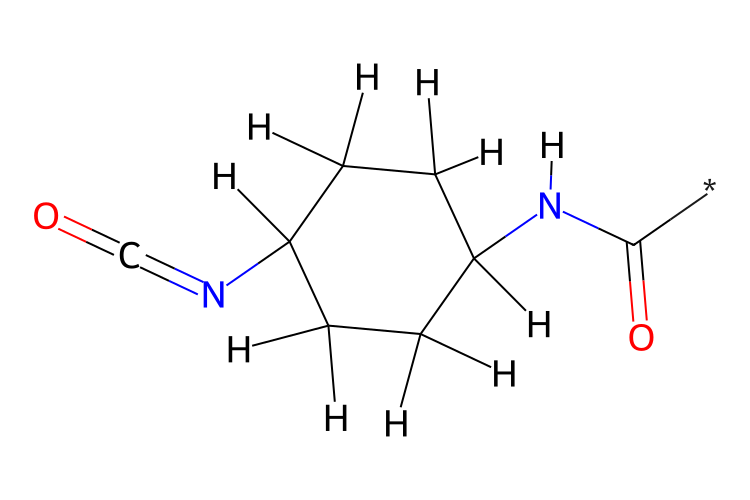

hydroxyl_TERM [*:1]-[#8:2]-[#6:3](-[H:4])(-[H:5])-[#6:6]1(-[H:7])-[#6:8](-[H:9])(-[H:10])-[#6:11]2(-[H:12])-[#6:13](-[H:14])(-[H:15])-[#6:16]-1(-[H:17])-[#6:18]1(-[H:19])-[#6:20](-[H:21])(-[H:22])-[#6:23](-[H:24])(-[H:25])-[#6:26](-[H:27])(-[#6:28](-[H:29])(-[H:30])-[#8:31]-[H:32])-[#6:33]-2-1-[H:34]


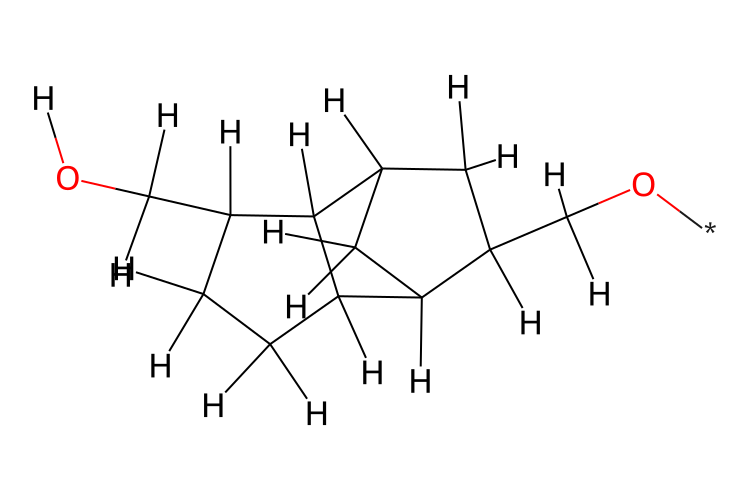

isocyanate_MID [*:1]-[#6:2](=[#8:3])-[#7:4](-[H:5])-[#6:6]1(-[H:7])-[#6:8](-[H:9])(-[H:10])-[#6:11](-[H:12])(-[H:13])-[#6:14](-[H:15])(-[#7:16](-[H:17])-[#6:18](-[*:19])=[#8:20])-[#6:21](-[H:22])(-[H:23])-[#6:24]-1(-[H:25])-[H:26]


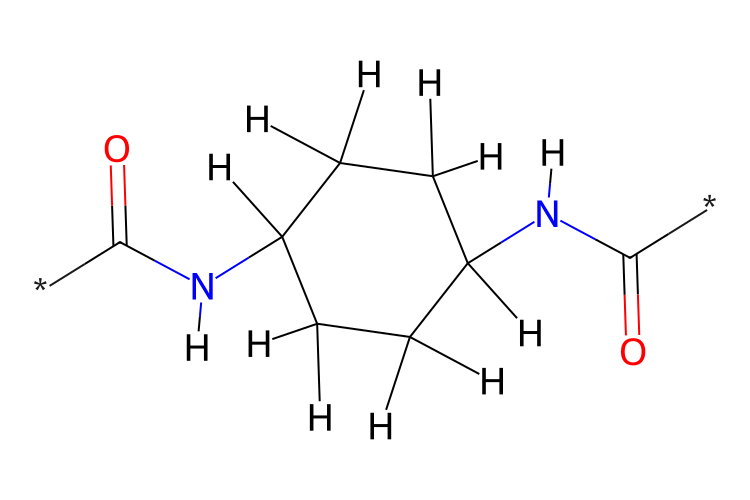

hydroxyl_MID [*:1]-[#8:2]-[#6:3](-[H:4])(-[H:5])-[#6:6]1(-[H:7])-[#6:8](-[H:9])(-[H:10])-[#6:11]2(-[H:12])-[#6:13](-[H:14])(-[H:15])-[#6:16]-1(-[H:17])-[#6:18]1(-[H:19])-[#6:20](-[H:21])(-[H:22])-[#6:23](-[H:24])(-[H:25])-[#6:26](-[H:27])(-[#6:28](-[H:29])(-[H:30])-[#8:31]-[*:32])-[#6:33]-2-1-[H:34]


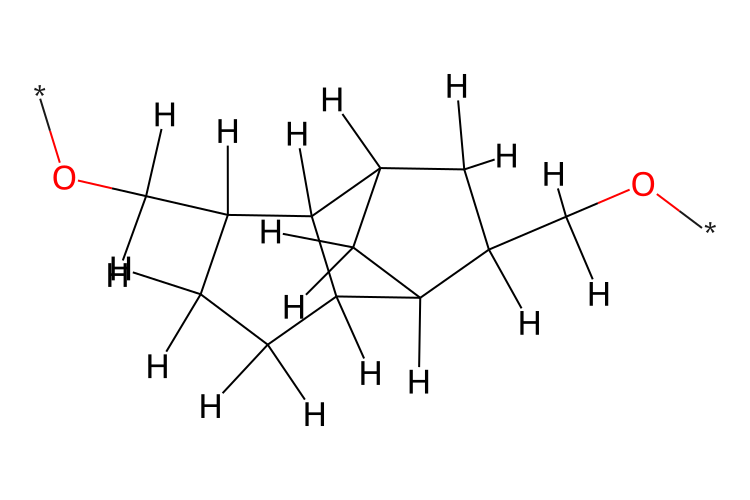

In [5]:
rdkdraw.set_rdkdraw_size(500, 3/2)
cvtr = rdconvert.SMILESConverter()

chemistry = 'urethane'
idx = 10

mono_info = MonomerInfo.from_file(MONO_INFO_DIR / chemistry / f'{chemistry}_{idx}.json')

mbmols = {}
def show(mono_info : MonomerInfo) -> None:
    for resname, smarts in mono_info.SMARTS.items():
        print(resname, smarts)
        mol = Chem.MolFromSmarts(smarts)
        mol = cvtr.convert(mol)
        Chem.SanitizeMol(mol)
        rdlabels.clear_atom_map_nums(mol, in_place=True)
        display(mol)

        # mbmol, ports = building.mbmol_from_mono_smarts(new_smarts)

        prot_mol = rdbond.hydrogenate_rdmol_ports(mol, in_place=False)
        mbmols[resname] = mb.conversion.from_rdkit(prot_mol)

show(mono_info)

# Generating managed polymer collections 

In [7]:
from polysaccharide.polymer.management import PolymerManager

coll_path = Path('Collections')
coll_path.mkdir(exist_ok=True)

for chemistry in chemistries:
    chem_path = coll_path / chemistry
    chem_path.mkdir(exist_ok=True)

    mgr = PolymerManager(chem_path)
    mgr.populate_collection(pdb_path / chemistry, MONO_INFO_DIR / chemistry)

In [ ]:
mgr = PolymerManager(coll_path / 'urethane')
pdir = mgr.polymers['urethane_4']
# pdir = mgr.polymers['NIPU_8']
offmol = pdir.offmol_matched(strict=False)
# pdir.offmol_matched(strict=True)

for atom in offmol.atoms:
    if not atom.metadata['already_matched']:
        print(atom.metadata)

In [8]:
mgr = PolymerManager(coll_path / 'NIPU')

offmols = {}
unmatched = []
for mol_name, polymer in mgr.polymers.items():
    try:
        offmols[mol_name] = polymer.offmol
    except:
        unmatched.append(mol_name)

In [9]:
unmatched

['NIPU_8', 'NIPU_10', 'NIPU_9']

In [ ]:
for mol_name in unmatched:
    print(mol_name)
    polymer = mgr.polymers[mol_name]
    offmol = polymer.offmol_matched(strict=False)
    
    for atom in offmol.atoms:
        if not atom.metadata['already_matched']:
            print('\t', atom.metadata)

In [ ]:
offmols